In [6]:
from datetime import datetime
import os
from time_utils.gpst import dt2gpst, gpst2dt, gpst_week_number, gpst_week_day

In [7]:
def format_filepath(filepath_expr, dt=None, params={}):
    '''
    ------------------------------------------------------------------------
    `filepath_expr` -- a formattable string that defines the full filepath.
        Intended to mirror filepath format on website / FTP site (should be
        mirrored by folder structure of downloaded files).  See below about
        placeholders.
        
    Placeholders:
        Use the Python format syntax for adding placeholders to the path or
        file expressions.  E.g. `/path/to/data/{type}/`.  These will be
        replaced via `.format` with `params` as the argument.
    
    Reserved Placeholders:
        For date/time-related expressions in the path or filename
        expressions, use the placeholders used on IGS products page (e.g.
        wwww, yyyy, ddd, etc).  When passing in a datetime into
        `format_filepath(<filepath>, dt=datetime)`, this function computes
        all the necessary placeholders.

    Example:
        IGS MGEX path expression: /pub/gps/products/mgex/{wwww}/
        IGS MGEX sp3 file expression: com{wwww}{d}.sp3.Z
        New MGEX SP3 file expression: COD0MGXFIN_{yyyy}{ddd}0000_01D_05M_ORB.SP3.gz
    
    Note on `path_expression` leading '/':
        Strips leading forward slash in path expression to avoid issues
        with `join`.  Path expression is always relative to some host URL
        or local data directory.

    Note for SP3:
        For MGEX (basepath = '/pub/igs/products/mgex'), we can use the `com` files which include all available GNSS data
        When using basepath pub/products/ ...:
            for GPS use 'igs';
            for GLONASS use 'igl' (after GPS week 1300) or 'igx' (before GPS week 1300)
    '''
    if dt is not None:
        gpst = dt2gpst(dt)
        week_no = gpst_week_number(gpst)
        week_day = gpst_week_day(gpst)
        yyyy = '{0:04}'.format(dt.year)                # year
        yy = '{0:02}'.format(dt.year % 100)            # 2-digit year
        mm = '{0:02}'.format(dt.month)                 # month
        wwww = '{0:04}'.format(week_no)       # gps week no.
        ddd = '{0:03}'.format(dt.timetuple().tm_yday)  # day of year
        d = '{0:01}'.format(int(week_day))    # day of week
        date_params = {'yyyy': yyyy, 'yy': yy, 'mm': mm, 'wwww': wwww, 'ddd': ddd, 'd': d}
        params.update(date_params)
    return filepath_expr.format(**params)

In [8]:
from ftplib import FTP
from os.path import basename, dirname, join, exists
from os import makedirs

def ftp_download(ftp_host, url_filepath, output_filepath):
    '''Given URL to data on FTP site and a local output location, uses Python
    FTP library's `retrbinary` function to download file.
    '''
    path = dirname(url_filepath)
    filename = basename(url_filepath)
    ftp = FTP(ftp_host)
    ftp.login()
    ftp.cwd(path)
    with open(output_filepath, 'wb') as f:
        ftp.retrbinary('RETR ' + filename, f.write)
    ftp.quit()
    return True

In [9]:
import zipfile
import tarfile

import gzip
import shutil

rarfile = None
try:
    import rarfile
except ImportError:
    msg = '`rarfile` package not found.  ".rar" file decompression will not be available'
    print(msg)
    #raise ImportError(msg)

from os.path import dirname, join, basename
import subprocess


def fix_bad_zip_file(zipFile):
    '''See here:  https://stackoverflow.com/questions/3083235/unzipping-file-results-in-badzipfile-file-is-not-a-zip-file'''
    with open(zipFile, 'rb') as f:
        data = f.read()
        pos = data.find(b'\x50\x4b\x05\x06') # End of central directory signatur
        if (pos > 0):
            self._log("Trancating file at location " + str(pos + 22)+ ".")
            f.seek(pos + 22)   # size of 'ZIP end of central directory record'
            f.truncate()  
            f.close()  
        else:
            # raise error, file is truncated
            raise Exception('Bad zip file: file is truncated')


def decompress(filepath, output_filepath):
    '''
    ----------------------------------------------------------------------------
    Given the path to file `filepath`, determines whether one of the modules
    `zipfile`, `tarfile`, `gzip`, or (if available) `rarfile` is capable of 
    reading and decompressing the file.  Then, decompresses file and writes to
    `output_filepath`.  Returns False if decompression fails.

    Notes:  `gzip` module will only be used if filepath ends in '.gz'
    '''
    path = dirname(filepath)
    if zipfile.is_zipfile(filepath):
        with zipfile.ZipFile(filepath, 'r') as f:
            res = f.extractall(path)
        return join(path, basename(output_filepath)) == output_filepath
    if tarfile.is_tarfile(filepath):
        with tarfile.TarFile(filepath, 'r') as f:
            f.extractall(path)
        return join(path, basename(output_filepath)) == output_filepath
    if rarfile is not None:
        if rarfile.is_rarfile(filepath):
            with rarfile.RarFile(filepath, 'r') as f:
                f.extractall(path)
            return join(path, basename(output_filepath)) == output_filepath
    if filepath[-3:] == '.gz':
        with gzip.open(filepath, 'rb') as f_in:
            with open(output_filepath, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)
        return output_filepath
    if filepath[-2:] in ['.Z', '.z']:
        # Unix compression; use uncompress
        res = subprocess.call('uncompress -f ' + filepath, shell=True)
        if res == 0:
            return filepath[:-2] == output_filepath
    # check for bad zip file
    if filepath[-4:] in ['.zip']:
        res = subprocess.call('unzip ' + filepath, shell=True)
        if res == 0:
            return filepath[:-4] == output_filepath
    return False

`rarfile` package not found.  ".rar" file decompression will not be available


In [10]:
ftp_host = 'cddis.gsfc.nasa.gov'
filepath_template = \
    'pub/gps/data/daily/{yyyy}/{ddd}/{yy}o/nist{ddd}0.{yy}o.Z'
url_filepath = format_filepath(filepath_template, datetime(2017, 8, 21))

In [11]:
filepath = os.path.join('/Users/liuzijun 1/Projects/gnss-research/data/rinex/', url_filepath)
if not os.path.exists(os.path.dirname(filepath)):
    os.makedirs(os.path.dirname(filepath))
if not os.path.exists(filepath):
    success = ftp_download(ftp_host, url_filepath, filepath)
subprocess.call('uncompress -f ' + filepath.replace(' ', '\ '), shell=True)
filepath = filepath[:-2]

In [7]:
from rinex2 import parse_RINEX2_obs_file

In [8]:
header, observations = parse_RINEX2_obs_file(filepath)

In [9]:
satellites = observations['satellites']
satellites.keys()

dict_keys(['G10', 'G13', 'G15', 'G16', 'G18', 'G20', 'G21', 'G24', 'G27', 'G29', 'G32', 'G08', 'G14', 'G11', 'G31', 'G01', 'G25', 'G22', 'G12', 'G03', 'G26', 'G23', 'G09', 'G06', 'G07', 'G30', 'G28', 'G05', 'G17', 'G19', 'G02'])

In [10]:
sat = satellites['G01']

In [11]:
sat.keys()

dict_keys(['L1', 'L2', 'index'])

In [12]:
sig = sat['L1']

In [13]:
sig.keys()

dict_keys(['pseudorange', 'carrier', 'doppler', 'snr'])

In [14]:
import matplotlib.pyplot as plt

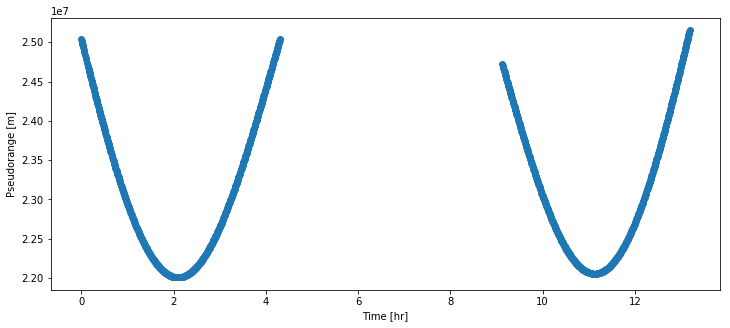

In [15]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time / 3600, sat['L1']['pseudorange'])
# ax.scatter(time / 3600, sat['L2']['pseudorange'])
ax.set_ylabel('Pseudorange [m]')
ax.set_xlabel('Time [hr]')
plt.show()

In [16]:
from scipy.constants import c

In [17]:
kappa = 40.308
fL1 = 1.57542e9
fL2 = 1.2276e9
P1 = sat['L1']['pseudorange']
P2 = sat['L2']['pseudorange']
TEC = (P1 - P2) / (kappa * (1 / fL1**2 - 1 / fL2**2))

L1 = sat['L1']['carrier'] * c / fL1
L2 = sat['L2']['carrier'] * c / fL2
TEC_rel = -(L1 - L2) / (kappa * (1 / fL1**2 - 1 / fL2**2))

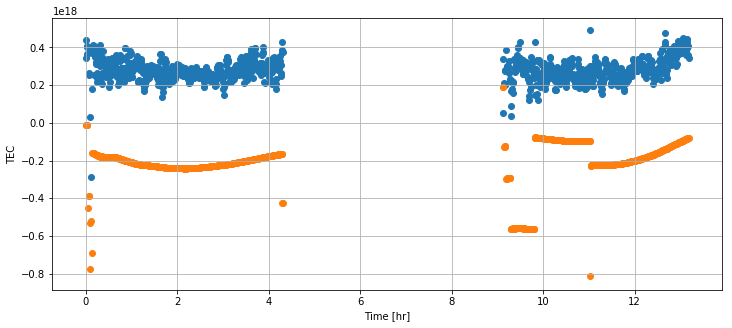

In [18]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

time = observations['time'][sat['index']]
time -= time[0]
ax.scatter(time / 3600, TEC)
ax.scatter(time / 3600, TEC_rel)
ax.set_ylabel('TEC')
ax.set_xlabel('Time [hr]')
ax.grid()
plt.show()

$$
f_\text{L1} = 1.57542 \times 10^9 \text{Hz}  \\
f_\text{L2} = 1.2276 \times 10^9 \text{Hz}
$$

$$
P_f = \rho + I_f + \epsilon_{P_f}
$$

$$
\kappa \approx 40.308
$$

$$
I_f = \frac{\kappa}{f^2} \text{TEC}
$$

$$
P_\text{L1} = \rho + I_\text{L1} + \epsilon_{P_\text{L1}}
\\
P_\text{L2} = \rho + I_\text{L2} + \epsilon_{P_\text{L2}}
$$

$$
\begin{align*}
P_\text{L1} - P_\text{L2}
& = I_\text{L1} + \epsilon_{P_\text{L1}} - I_\text{L2} - \epsilon_{P_\text{L2}}
\\
& = I_\text{L1}  - I_\text{L2} + \epsilon_{P_{\text{L1},\text{L2}}}
\\
& = \frac{\kappa}{f_\text{L1}^2} \text{TEC} - \frac{\kappa}{f_\text{L2}^2}\text{TEC} + \epsilon_{P_{\text{L1},\text{L2}}}
\\
& = \kappa \frac{\left(f_\text{L2}^2 - f_\text{L1}^2 \right)}{f_\text{L1}^2f_\text{L2}^2}
\text{TEC} + \epsilon_{P_{\text{L1},\text{L2}}}
\\
& = \kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) \text{TEC} + \epsilon_{P_{\text{L1},\text{L2}}}
\\
& \approx \kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) \text{TEC}
\end{align*}
$$

$$
\Rightarrow \text{TEC} = \frac{P_\text{L1} - P_\text{L2}}{\kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) }
$$

$$
L_\text{L1} = \rho - I_\text{L1} + \lambda_\text{L1} N_\text{L1} + \epsilon_{P_\text{L1}}
\\
L_\text{L2} = \rho - I_\text{L2} + \lambda_\text{L2} N_\text{L2} + \epsilon_{P_\text{L2}}
$$

$$
\begin{align*}
L_\text{L1} - L_\text{L2}
& = -I_\text{L1} + \epsilon_{P_\text{L1}} + I_\text{L2} - \epsilon_{L_\text{L2}}
\\
& = -I_\text{L1}  + I_\text{L2} + \epsilon_{L_{\text{L1},\text{L2}}}
\\
& = \kappa \left(-\frac{1}{f_\text{L1}^2} + \frac{1}{f_\text{L2}^2} \right) \text{TEC} + \epsilon_{L_{\text{L1},\text{L2}}}
\\
& \approx \kappa \left(-\frac{1}{f_\text{L1}^2} + \frac{1}{f_\text{L2}^2} \right) \text{TEC}
\end{align*}
$$

$$
\Rightarrow \text{TEC} = -\frac{L_\text{L1} - L_\text{L2}}{\kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) }
$$

$$
f_\text{L1} = 1.57542 \times 10^9 \text{Hz}  \\
f_\text{L2} = 1.2276 \times 10^9 \text{Hz} \\
P_f = \rho + I_f + \epsilon_{P_f} \\
$$

$$
P_\text{L1} = \rho + I_\text{L1} + \epsilon_{P_\text{L1}}
\\
P_\text{L2} = \rho + I_\text{L2} + \epsilon_{P_\text{L2}}
$$

$$
\begin{align*}
P_\text{L1} - P_\text{L2}
& = I_\text{L1} + \epsilon_{P_\text{L1}} - I_\text{L2} - \epsilon_{P_\text{L2}}
\\
& = I_\text{L1}  - I_\text{L2} + \epsilon_{P_{\text{L1},\text{L2}}}\\
&\Rightarrow \text{TEC} = \frac{P_\text{L1} - P_\text{L2}}{\kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) }
\end{align*}
$$

$$
L_\text{L1} = \rho - I_\text{L1} + \lambda_\text{L1} N_\text{L1} + \epsilon_{P_\text{L1}}
\\
L_\text{L2} = \rho - I_\text{L2} + \lambda_\text{L2} N_\text{L2} + \epsilon_{P_\text{L2}}
$$
$$
\begin{align*}
L_\text{L1} - L_\text{L2}
& = -I_\text{L1} + \epsilon_{P_\text{L1}} + I_\text{L2} - \epsilon_{L_\text{L2}} \\
& = -I_\text{L1}  + I_\text{L2} + \epsilon_{L_{\text{L1},\text{L2}}}
\\
& \Rightarrow \text{TEC} = -\frac{L_\text{L1} - L_\text{L2}}{\kappa \left(\frac{1}{f_\text{L1}^2} - \frac{1}{f_\text{L2}^2} \right) } \\
\end{align*}
$$

Ionosphere total electron content (TEC) is a measure of the 

$\textbf{TEC}$: means that total electron content and the number of electrons in a tube of 1 $m^2$ cross section extending from the receiver to the satellite. 
